In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Assignment/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Assignment


In [2]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import Dataset

trainloader = Dataset.trainloader
testloader =  Dataset.testloader
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


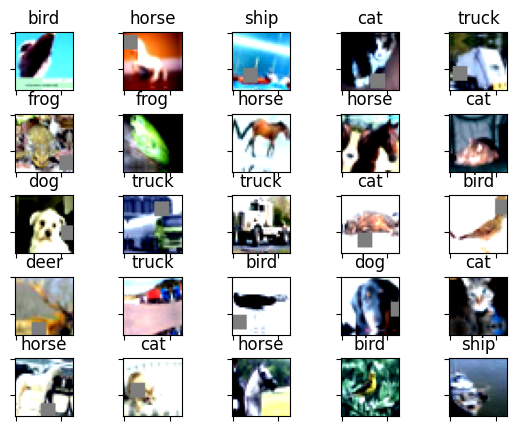

In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# print labels
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(0,25):
 plt.subplot(5, 5, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((images[i]/2)+0.5).numpy(),(1,2,0)))
 plt.title(classes[labels[i]])

#Network

In [5]:
import custom_resnet
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = custom_resnet.Net('bn').to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [7]:
!pip install torch-lr-finder

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


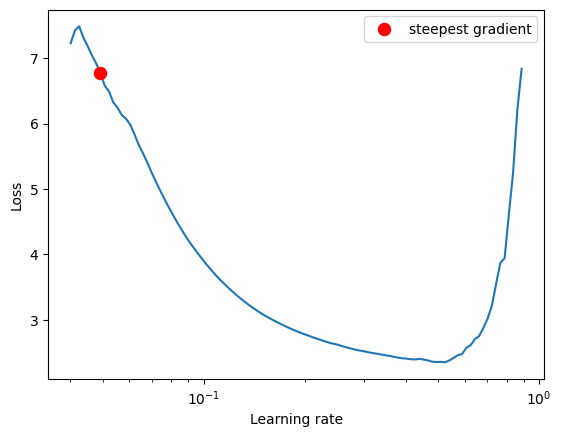

In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.03, weight_decay=1e-4)
lr_finder = LRFinder(net, optimizer, criterion, device='cuda')
lr_finder.range_test(trainloader,end_lr=10, num_iter=200, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [12]:
from torch.optim.lr_scheduler import OneCycleLR
Epoch = 24
scheduler = OneCycleLR(optimizer, max_lr=4.93E-02, steps_per_epoch=len(trainloader),epochs=Epoch, pct_start=5/Epoch, div_factor=100, final_div_factor=100, three_phase=False, anneal_strategy='linear')

In [13]:
import torch
from tqdm import tqdm
import traine, teste
#import test
test_acc = []
train_acc = []
learning_rate = []
for epoch in range(Epoch):  # loop over the dataset multiple times
    scheduler.step()
    for param_group in optimizer.param_groups:
      print("lr= ",param_group['lr'])
    train_acc.append(traine.train(net, device, trainloader, optimizer, criterion, epoch))
    test_acc.append(teste.test(net, device, testloader))
    learning_rate.append(param_group['lr'])
print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


lr=  0.0005179779938587512


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 391/391 [00:37<00:00, 10.56it/s]


Epoch= 0 Loss=0.9108046293258667 Accuracy=76.25


100%|██████████| 79/79 [00:05<00:00, 13.41it/s]


Accuracy of the network on the 10000 test images: 69.91 %
lr=  0.0005429559877175025


100%|██████████| 391/391 [00:37<00:00, 10.51it/s]


Epoch= 1 Loss=0.5928165912628174 Accuracy=83.75


100%|██████████| 79/79 [00:05<00:00, 14.15it/s]


Accuracy of the network on the 10000 test images: 75.65 %
lr=  0.0005679339815762537


100%|██████████| 391/391 [00:37<00:00, 10.43it/s]


Epoch= 2 Loss=0.6605222821235657 Accuracy=82.50


100%|██████████| 79/79 [00:05<00:00, 14.67it/s]


Accuracy of the network on the 10000 test images: 82.48 %
lr=  0.000592911975435005


100%|██████████| 391/391 [00:37<00:00, 10.56it/s]


Epoch= 3 Loss=0.5931054353713989 Accuracy=83.75


100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


Accuracy of the network on the 10000 test images: 84.55 %
lr=  0.0006178899692937563


100%|██████████| 391/391 [00:37<00:00, 10.32it/s]


Epoch= 4 Loss=0.5571684837341309 Accuracy=86.25


100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Accuracy of the network on the 10000 test images: 85.49 %
lr=  0.0006428679631525076


100%|██████████| 391/391 [00:37<00:00, 10.37it/s]


Epoch= 5 Loss=0.4292464256286621 Accuracy=86.25


100%|██████████| 79/79 [00:05<00:00, 14.49it/s]


Accuracy of the network on the 10000 test images: 84.91 %
lr=  0.0006678459570112589


100%|██████████| 391/391 [00:38<00:00, 10.27it/s]


Epoch= 6 Loss=0.6074680089950562 Accuracy=80.00


100%|██████████| 79/79 [00:05<00:00, 14.43it/s]


Accuracy of the network on the 10000 test images: 87.66 %
lr=  0.0006928239508700102


100%|██████████| 391/391 [00:39<00:00,  9.98it/s]


Epoch= 7 Loss=0.24752846360206604 Accuracy=93.75


100%|██████████| 79/79 [00:05<00:00, 14.14it/s]


Accuracy of the network on the 10000 test images: 88.24 %
lr=  0.0007178019447287615


100%|██████████| 391/391 [00:38<00:00, 10.17it/s]


Epoch= 8 Loss=0.42044568061828613 Accuracy=87.50


100%|██████████| 79/79 [00:07<00:00, 10.16it/s]


Accuracy of the network on the 10000 test images: 88.23 %
lr=  0.0007427799385875127


100%|██████████| 391/391 [00:36<00:00, 10.69it/s]


Epoch= 9 Loss=0.37224358320236206 Accuracy=88.75


100%|██████████| 79/79 [00:06<00:00, 12.22it/s]


Accuracy of the network on the 10000 test images: 89.17 %
lr=  0.0007677579324462641


100%|██████████| 391/391 [00:44<00:00,  8.80it/s]


Epoch= 10 Loss=0.2755456566810608 Accuracy=95.00


100%|██████████| 79/79 [00:06<00:00, 12.74it/s]


Accuracy of the network on the 10000 test images: 88.81 %
lr=  0.0007927359263050153


100%|██████████| 391/391 [00:38<00:00, 10.17it/s]


Epoch= 11 Loss=0.31451207399368286 Accuracy=93.75


100%|██████████| 79/79 [00:07<00:00, 10.01it/s]


Accuracy of the network on the 10000 test images: 88.48 %
lr=  0.0008177139201637665


100%|██████████| 391/391 [00:36<00:00, 10.57it/s]


Epoch= 12 Loss=0.21096256375312805 Accuracy=96.25


100%|██████████| 79/79 [00:05<00:00, 13.91it/s]


Accuracy of the network on the 10000 test images: 88.82 %
lr=  0.0008426919140225178


100%|██████████| 391/391 [00:37<00:00, 10.35it/s]


Epoch= 13 Loss=0.22360393404960632 Accuracy=95.00


100%|██████████| 79/79 [00:05<00:00, 14.31it/s]


Accuracy of the network on the 10000 test images: 89.52 %
lr=  0.000867669907881269


100%|██████████| 391/391 [00:37<00:00, 10.36it/s]


Epoch= 14 Loss=0.41312193870544434 Accuracy=90.00


100%|██████████| 79/79 [00:05<00:00, 13.92it/s]


Accuracy of the network on the 10000 test images: 89.00 %
lr=  0.0008926479017400204


100%|██████████| 391/391 [00:38<00:00, 10.21it/s]


Epoch= 15 Loss=0.38786235451698303 Accuracy=91.25


100%|██████████| 79/79 [00:05<00:00, 13.93it/s]


Accuracy of the network on the 10000 test images: 89.44 %
lr=  0.0009176258955987716


100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


Epoch= 16 Loss=0.45277827978134155 Accuracy=88.75


100%|██████████| 79/79 [00:06<00:00, 12.83it/s]


Accuracy of the network on the 10000 test images: 90.10 %
lr=  0.0009426038894575229


100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


Epoch= 17 Loss=0.21539346873760223 Accuracy=96.25


100%|██████████| 79/79 [00:07<00:00, 10.46it/s]


Accuracy of the network on the 10000 test images: 90.33 %
lr=  0.0009675818833162742


100%|██████████| 391/391 [00:37<00:00, 10.36it/s]


Epoch= 18 Loss=0.44916099309921265 Accuracy=91.25


100%|██████████| 79/79 [00:05<00:00, 13.76it/s]


Accuracy of the network on the 10000 test images: 90.03 %
lr=  0.0009925598771750254


100%|██████████| 391/391 [00:37<00:00, 10.34it/s]


Epoch= 19 Loss=0.3649859130382538 Accuracy=95.00


100%|██████████| 79/79 [00:05<00:00, 13.97it/s]


Accuracy of the network on the 10000 test images: 89.99 %
lr=  0.0010175378710337768


100%|██████████| 391/391 [00:38<00:00, 10.22it/s]


Epoch= 20 Loss=0.3628840148448944 Accuracy=92.50


100%|██████████| 79/79 [00:05<00:00, 14.00it/s]


Accuracy of the network on the 10000 test images: 89.58 %
lr=  0.0010425158648925282


100%|██████████| 391/391 [00:39<00:00, 10.00it/s]


Epoch= 21 Loss=0.3417513072490692 Accuracy=93.75


100%|██████████| 79/79 [00:05<00:00, 13.67it/s]


Accuracy of the network on the 10000 test images: 90.13 %
lr=  0.0010674938587512794


100%|██████████| 391/391 [00:39<00:00,  9.87it/s]


Epoch= 22 Loss=0.35375428199768066 Accuracy=96.25


100%|██████████| 79/79 [00:07<00:00, 10.50it/s]


Accuracy of the network on the 10000 test images: 90.59 %
lr=  0.0010924718526100306


100%|██████████| 391/391 [00:37<00:00, 10.50it/s]


Epoch= 23 Loss=0.34181419014930725 Accuracy=93.75


100%|██████████| 79/79 [00:06<00:00, 11.71it/s]

Accuracy of the network on the 10000 test images: 90.49 %
Finished Training


## Train/Test/LR curve

Text(0, 0.5, 'lr')

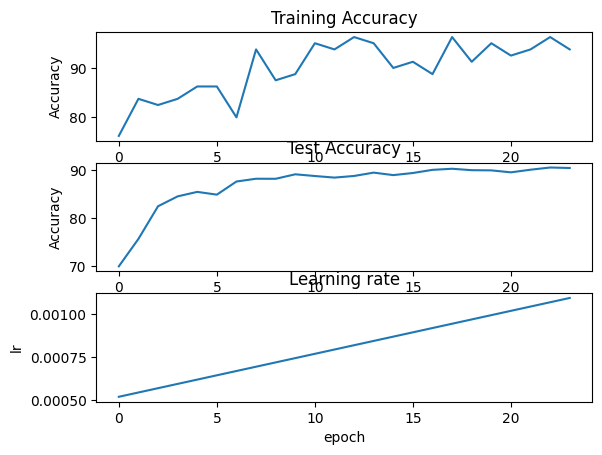

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")
axs[2].plot(learning_rate)
axs[2].set_title("Learning rate")
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("lr")

## Misclassified Images

  0%|          | 0/79 [00:04<?, ?it/s]


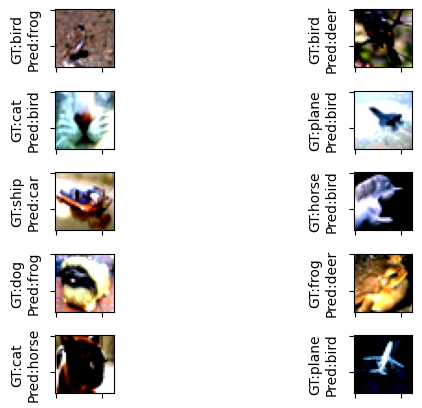

In [16]:
from tqdm import tqdm
net.eval()
missed = []
with torch.no_grad():
      pbar1 = tqdm(testloader)
      for i, (data, target) in enumerate(pbar1):
           data, target = data.to(device), target.to(device)
           outputs = net(data)
           _, predicted = torch.max(outputs.data, 1)
           target1 = target.cpu().numpy()
           predicted1 = predicted.cpu().numpy()
           for i in range(64):
              if target1[i]!=predicted1[i]:
                 missed.append(i)
           break

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(0,10):
 plt.subplot(5, 2, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((data[missed[i]].cpu()/2)+0.5).numpy(),(1,2,0)))
 plt.ylabel("GT:"+str(classes[target1[missed[i]]])+'\nPred:'+str(classes[predicted1[missed[i]]]))



## Correctly classified Images

  0%|          | 0/79 [00:03<?, ?it/s]


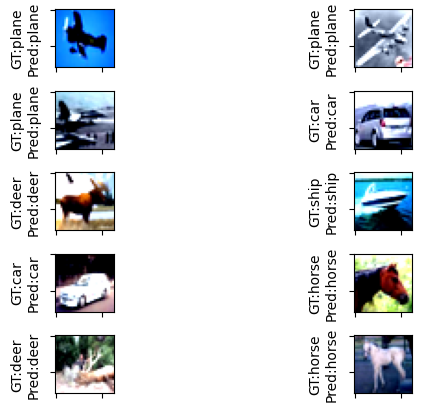

In [17]:
from tqdm import tqdm
net.eval()
missed = []
with torch.no_grad():
      pbar1 = tqdm(testloader)
      for i, (data, target) in enumerate(pbar1):
           data, target = data.to(device), target.to(device)
           outputs = net(data)
           _, predicted = torch.max(outputs.data, 1)
           target1 = target.cpu().numpy()
           predicted1 = predicted.cpu().numpy()
           for i in range(64):
              if target1[i]==predicted1[i]:
                 missed.append(i)
           break

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
for i in range(0,10):
 plt.subplot(5, 2, i+1)
 frame1 = plt.gca()
 frame1.axes.xaxis.set_ticklabels([])
 frame1.axes.yaxis.set_ticklabels([])
 plt.imshow(np.transpose(((data[missed[i]].cpu()/2)+0.5).numpy(),(1,2,0)))
 plt.ylabel("GT:"+str(classes[target1[missed[i]]])+'\nPred:'+str(classes[predicted1[missed[i]]]))

